In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sympy import *
from cvxopt import matrix,solvers 

In [2]:
X=pd.DataFrame(columns=['x1','x2','ω'])
for i in range(1,15):
    loc="poly/poly"+str(i)+".png"
    img=cv.imread(loc,0)
    #area, perimeter are rotation, translation invariant
    #resize to fixed size for scale invariance
    img=cv.resize(img,(322,322),interpolation=cv.INTER_AREA)
    width, height = img.shape
    for y in range(height):
        for x in range(width):
            if img[x, y] == 255:
                img[x, y] = 0
    contours,_=cv.findContours(img,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    j=0
    for contour in contours:
        if j==0:
            j=1
            continue
        area=cv.contourArea(contour)*1000/(322*322)
        perimeter=cv.arcLength(contour,True)*1000/(322*322)
        list=[round(area,2),round(perimeter,2)]
        if i in range(1,8):
            list.append(0)
        else:
            list.append(1)
        new_row=pd.DataFrame({'x1':list[0],'x2':list[1],'ω':list[2]},index=[0])
        X=pd.concat([new_row,X.loc[:]]).reset_index(drop=True)
        list.clear()
X=X.iloc[::-1].reset_index(drop=True)
Y=X.copy()
Y.insert(2,'x3',np.ones(14))
Y.loc[Y['ω']==1,['x1','x2','x3']]=-1*Y.loc[Y['ω']==1]
print(Y)

        x1     x2   x3  ω
0   450.05  10.02  1.0  0
1   333.75   9.45  1.0  0
2    407.5  10.77  1.0  0
3    407.5  10.76  1.0  0
4   435.55  10.59  1.0  0
5   435.53  10.62  1.0  0
6   447.62   9.97  1.0  0
7  -891.06 -11.71 -1.0  1
8  -891.06 -11.71 -1.0  1
9  -866.84 -11.55 -1.0  1
10 -929.54 -11.96 -1.0  1
11 -873.64 -11.59 -1.0  1
12 -932.82 -11.98 -1.0  1
13 -932.82 -11.98 -1.0  1


In [3]:
x1=Symbol('x1')
x2=Symbol('x2')
y=np.asarray([x1,x2,1])
x1w0=X.loc[X['ω']==0,['x1']]
x2w0=X.loc[X['ω']==0,['x2']]
x1w1=X.loc[X['ω']==1,['x1']]
x2w1=X.loc[X['ω']==1,['x2']]

perceptron

In [4]:
a=np.array([0,0,0])
eta=0.01
n=14  
i=0
loop=0
itr=0
while(loop<n-1):
     yi=np.asarray(Y[['x1','x2','x3']].iloc[i])
     if(a@yi.T<=0):
          a=a+eta*yi
          loop=-1
          itr=itr+1
     else:
          loop=loop+1
     i=(i+1)%n
print("a =",a)

a = [-0.1381999999999839 6.540100000000006 0.7800000000000005]


Decision Boundary: -0.138199999999984*x1 + 6.54010000000001*x2 + 0.78 = 0


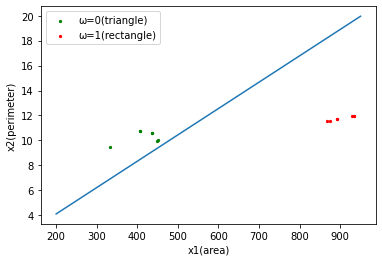

In [5]:
print("Decision Boundary:",a@y.T,"= 0")
g=solve(a@y.T,x2,dict=True)
xx=np.linspace(200,950,100)
yy=np.asarray([lambdify(x1,g[0][x2])(val) for val in xx])
plt.plot(xx,yy.T)
plt.scatter(x1w0,x2w0,label="ω=0(triangle)",color="green",marker=".",s=20)
plt.scatter(x1w1,x2w1,label="ω=1(rectangle)",color="red",marker=".",s=20) 
plt.xlabel('x1(area)')
plt.ylabel('x2(perimeter)')
plt.legend()
plt.show()

SVM

In [6]:
n=14
X=X[['x1','x2']].to_numpy()
Y=Y[['x3']].to_numpy()
H=np.dot(Y*X,(Y*X).T)
H=H.astype('float')
q=np.repeat([-1.0],n)[..., None]
A=Y.reshape(1,-1)
A=A.astype('float')
b=0.0
G=np.negative(np.eye(n))
h=np.zeros(n)
P=matrix(H)
q=matrix(q)
G=matrix(G)
h=matrix(h)
A=matrix(A)
b=matrix(b)
sol=solvers.qp(P,q,G,h,A,b)
alpha=np.array(sol['x'])
print("alpha =",alpha)
W=np.dot((Y*alpha).T,X)[0]
print("W =",W)
S=(alpha>1e-5).flatten()
b=np.mean(Y[S]-np.dot(X[S],W.reshape(-1,1)))
print("b =",b)

     pcost       dcost       gap    pres   dres
 0: -2.3139e-01 -2.7846e-01  2e+01  5e+00  1e+00
 1:  7.3595e-03  1.6255e-05  8e-01  2e-01  4e-02
 2:  7.1221e-05 -4.1237e-05  8e-03  2e-03  4e-04
 3:  3.7786e-06 -4.0740e-05  9e-05  1e-05  2e-06
 4: -6.6751e-06 -1.9504e-05  1e-05  3e-21  2e-15
 5: -9.2864e-06 -1.1974e-05  3e-06  3e-21  8e-16
 6: -1.0469e-05 -1.2515e-05  2e-06  4e-21  8e-16
 7: -1.1372e-05 -1.1546e-05  2e-07  3e-21  1e-15
 8: -1.1511e-05 -1.1513e-05  3e-09  5e-21  1e-15
Optimal solution found.
alpha = [[1.14855703e-05]
 [5.21568943e-10]
 [9.93283193e-10]
 [9.89024012e-10]
 [6.54191106e-10]
 [5.53419937e-10]
 [2.28392159e-08]
 [1.42459485e-09]
 [1.42459485e-09]
 [1.14967110e-05]
 [5.14909061e-10]
 [1.10380342e-08]
 [5.03915524e-10]
 [5.03915524e-10]]
W = [-0.0047985977802438 -1.7614344456711226e-05]
b = 3.1598026861175947


Decision Boundary: -0.0047985977802438*x1 - 1.76143444567112e-5*x2 + 3.15980268611759 = 0


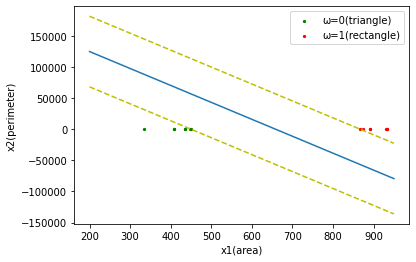

In [7]:
a=np.append(W,b)
print("Decision Boundary:",a@y.T,"= 0")
xx=np.linspace(200,950,100)
m=-W[0]/W[1]
yy=m*xx-(b)/W[1]
margin=1/np.sqrt(np.sum(W**2))
yy_neg=yy-np.sqrt(1+m**2)*margin
yy_pos=yy+np.sqrt(1+m**2)*margin
plt.plot(xx,yy)
plt.plot(xx,yy_neg,"y--")
plt.plot(xx,yy_pos,"y--")
plt.scatter(x1w0,x2w0,label="ω=0(triangle)",color="green",marker=".",s=20)
plt.scatter(x1w1,x2w1,label="ω=1(rectangle)",color="red",marker=".",s=20) 
plt.xlabel('x1(area)')
plt.ylabel('x2(perimeter)')
plt.legend()
plt.show()